In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
import re

import numpy as np
import tensorflow as tf
from transformers import pipeline
import torch

from summarizer import bpe_summarize, sentencizer
from validation.validation import scicummnet_validation, rouge_metric, similarity_score

In [47]:
validation_set = scicummnet_validation("validation/data/scisummnet_release1.1__20190413/")

In [96]:
random_sample = validation_set[np.random.randint(0, len(validation_set))]
assert random_sample is not None

In [217]:
sample_text, human_summary = random_sample
human_summary

'Extracting Parallel Sub-Sentential Fragments From Non-Parallel Corpora\nWe present a novel method for extracting parallel sub-sentential fragments from comparable, non-parallel bilingual corpora.\nBy analyzing potentially similar sentence pairs using a signal processing-inspired approach, we detect which segments of the source sentence are translated into segments in the target sentence, and which are not.\nThis method enables us to extract useful machine translation training data even from very non-parallel corpora, which contain no parallel sentence pairs.\nWe evaluate the quality of the extracted data by showing that it improves the performance of a state-of-the-art statistical machine translation system.\nWe first use the GI ZA++ (with grow-diag-final-and heuristic) to obtain the word alignment between source and target words, and then calculate the association strength between the aligned words.\nWe first extract the candidate parallel sentences from the comparable corpora and fu

In [218]:
bpe_summary = bpe_summarize(sample_text[:1024], percentile=70)
bpe_summary = re.sub(r"\n|\s{2,99}", "", bpe_summary)
bpe_summary

'Extracting Parallel Sub-Sentential Fragments From Non-Parallel CorporaWe present a novel method for extracting parallel sub-sentential fragments from comparable, non-parallel bilingual corpora. By analyzing potentially similar sentence pairs using a signal processinginspired approach, we detect which segments of the source sentence are translated into segments in the target sentence, and which are not. Several researchers (Zhao and Vogel, 2002; Vogel, 2003; Resnik and Smith, 2003; Fung and Cheung, 2004a; Wu and Fung, 2005; Munteanu and Marcu, 2005) have shown how fairly good-quality'

In [222]:
mean_rouge_fscore(bpe_summary, human_summary)

0.37931034080166465

In [223]:
similarity_score(bpe_summary, human_summary)

-0.48046875

In [182]:
bart_summarizer = pipeline("summarization")

In [219]:
maxlen = len(sample_text[:1024].split(" "))
bart_summary = bart_summarizer(sample_text[:1024], min_length=10, max_length=maxlen)
bart_summary[0]['summary_text']

'We present a novel method for extracting parallel sub-sentential fragments from comparable, non-parallel bilingual corpora. By analyzing potentially similar sentence pairs, we detect which segments of the source sentence are translated into segments in the target sentence. We evaluate the quality of the extracted data by showing that it improves the performance of a state-of-the-art statistical machine translation system.'

In [220]:
mean_rouge_fscore(bart_summary[0]['summary_text'], human_summary)

0.43283581746185124

In [221]:
similarity_score(bart_summary[0]['summary_text'], human_summary)

-0.57421875

In [117]:
!pip install matplotlib

  Using cached https://files.pythonhosted.org/packages/1d/f6/4362df6969f25973eb04ee0ab147588401928faddebe19c73d222fd13161/matplotlib-3.2.1-cp38-cp38-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f6/d7/d7516741c1043c3b9a55b9eb7762ec06bab4df1187705efd7dbb37d6f5ee/kiwisolver-1.2.0-cp38-cp38-macosx_10_9_x86_64.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [124]:
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [137]:
sample_size = 100

In [245]:
bart_scores = []
bart_summaries = []
for sample_text, human_summary in tqdm(validation_set[:sample_size]):
    maxlen = len(sample_text[:1024].split(" "))
    bart_summary = bart_summarizer(sample_text[:1024], min_length=10, max_length=maxlen)
    bart_summaries.append(bart_summary)
    bart_scores.append(similarity_score(bart_summary[0]['summary_text'], human_summary))

100%|██████████| 100/100 [14:33<00:00,  8.74s/it]


In [213]:
np.mean(bart_scores)

-0.48085952

In [237]:
bpe_scores = []
bpe_summaries = []
for sample_text, human_summary in tqdm(validation_set[:sample_size]):
    bpe_summary = bpe_summarize(sample_text[:1024], percentile=70)
    bpe_summary = re.sub(r"\n|\s{2,99}", "", bpe_summary)
    bpe_summaries.append(bpe_summary)
    bpe_scores.append(similarity_score(bpe_summary, human_summary))

100%|██████████| 100/100 [00:00<00:00, 131.60it/s]


In [214]:
np.mean(bpe_scores)

-0.54522026

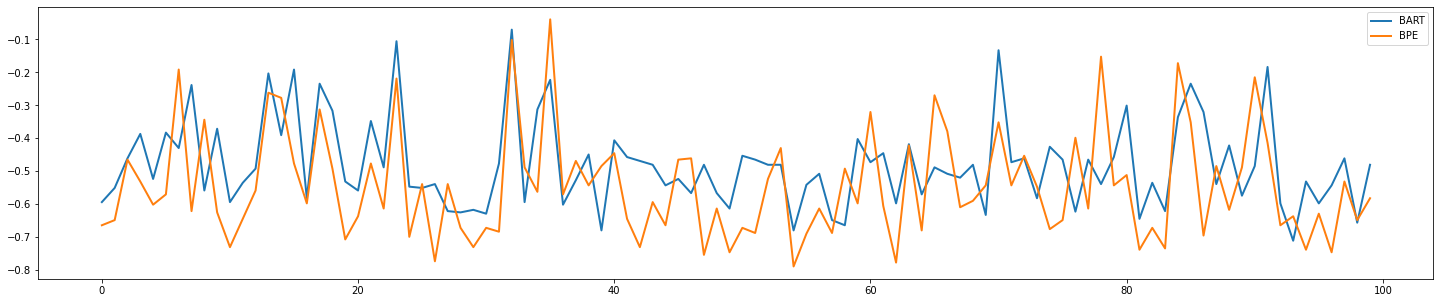

In [210]:
##### %matplotlib inline
fig = plt.figure(figsize=(25,5))
ax = fig.gca()
ax.plot(np.array(bart_scores), linewidth=2, label='BART')
ax.plot(np.array(bpe_scores), linewidth=2, label='BPE')
ax.legend()

In [269]:
# closer to -1 indicate greater similarity
best_bpe = np.min(bpe_scores)
print(best_bpe)
best = bpe_scores.index(best_bpe)
_,human = validation_set[:sample_size][best]
human

-0.7890625


"Fluency Adequacy or HTER? Exploring Different Human Judgments with a Tunable MT Metric\nAutomatic Machine Translation (MT) evaluation metrics have traditionally been evaluated by the correlation of the scores they assign to MT output with human judgments of translation performance.\nDifferent types of human judgments, such as Fluency, Adequacy, and HTER, measure varying aspects of MT performance that can be captured by automatic MT metrics.\nWe explore these differences through the use of a new tunable MT metric: TER-Plus, which extends the Translation Edit Rate evaluation metric with tunable parameters and the incorporation of morphology, synonymy and paraphrases.\nTER-Plus was shown to be one of the top metrics in NIST's Metrics MATR 2008 Challenge, having the highest average rank in terms of Pearson and Spearman correlation.\nOptimizing TER-Plus to different types of human judgments yields significantly improved correlations and meaningful changes in the weight of different types o

In [244]:
bpe_summaries[best]

'Exploring Different Human Judgments with a Tunable MT MetricAutomatic Machine Translation (MT) evaluation metrics have traditionally been evaluated by the correlation of the scores they assign to MT output with human judgments of translation performance. We explore these differences through the use of a new tunable MT metric: TER-Plus, which extends the Translation Edit Rate evaluation metric with tunable parameters and the incorporation of morphology, synonymy and paraphrases. Optimizing TER-Plus to different types of human judgments yields significantly improved correlations and meaningful changes in the weight of different types'

In [246]:
# closer to -1 indicate greater similarity
best_bpe = np.min(bart_scores)
print(best_bpe)
best = bart_scores.index(best_bpe)
_,human = validation_set[:sample_size][best]
human

-0.7109375


'Interpretation As Abduction\nAn approach to abductive inference developed in the TACITUS project has resulted in a dramatic simplification of how the problem of interpreting texts is conceptualized.\nIts use in solving the local pragmatics problems of reference, compound nominals, syntactic ambiguity, and metonymy is described and illustrated.\nIt also suggests an elegant and thorough integration of syntax, semantics, and pragmatics.\n'

In [253]:
bart_summaries[best][0]["summary_text"]

'An approach to abductive inference developed in the TACITUS project has resulted in a dramatic simplification of how the problem of interpreting texts is conceptualized. Its use in solving local pragmatics problems of reference, compound nominals, syntactic ambiguity, and metonymy is described and illustrated.'

In [272]:
t,human = validation_set[:sample_size][best]
result = bpe_summarize(t[:1024], percentile=70)
re.sub(r"\n|\s{2,99}", "", result)
t

'\n  Fluency Adequacy or HTER? Exploring Different Human Judgments with a Tunable MT Metric\n  \n    Automatic Machine Translation (MT) evaluation metrics have traditionally been evaluated by the correlation of the scores they assign to MT output with human judgments of translation performance.\n    Different types of human judgments, such as Fluency, Adequacy, and HTER, measure varying aspects of MT performance that can be captured by automatic MT metrics.\n    We explore these differences through the use of a new tunable MT metric: TER-Plus, which extends the Translation Edit Rate evaluation metric with tunable parameters and the incorporation of morphology, synonymy and paraphrases.\n    TER-Plus was shown to be one of the top metrics in NIST&#8217;s Metrics MATR 2008 Challenge, having the highest average rank in terms of Pearson and Spearman correlation.\n    Optimizing TER-Plus to different types of human judgments yields significantly improved correlations and meaningful changes 